# Ensemble methods


During this classes we implement few ensemble methods:
* boosting,
* bagging.

There are more explained in the lectures. 

## AdaBoost

AdaBoost consists of following steps:
* initialize weights to $\frac{1}{N}$, where $N$ is the number of datapoints,
* loop until 
  $\varepsilon_{t}<\frac{1}{2}$
  or maximum number of iteration is reached,

* train classifier on ${S,w^{(t)}}$ and get a hypothesis $h_{t}(x_{n})$ for datapoints $x_{n}$,

* compute error $\varepsilon_{t}=\sum_{n=1}^{N}w_{n}^{(t)}I(y_{n}\neq h_{t}(x_{n}))$,       

* set $\alpha_{t}=\log(\frac{1-\varepsilon_{t}}{\varepsilon_{t}})$.
  
* update weights $w_{n}^{(t+1)}=\frac{w_{n}^{(t)}\exp{\alpha_{t}I(y_{n}\neq h_{t}(x_{n}))}}{Z_{t}}$,
  where $Z_{t}$ is a normalization constant,

* output $f(X)=\text{sign}(\sum_{t=1}^{T}\alpha_{t}h_{t}(x))$.
  
Example taken from Marsland, Machine Learning: https://seat.massey.ac.nz/personal/s.r.marsland/MLBook.html.


First, we need to import libraries:

In [1]:
import pylab as pl
import numpy as np

%matplotlib inline

The training part consis

In [2]:
def train(data,classes,weights,whichdim):
    error = np.zeros(10)
    for value in range(0,10,1):
        val = float(value)/10
        classn = np.where(data[whichdim,:]<val,-1,1)
        ind = np.where(classes!=classn)
        error[value] = np.sum(weights[ind])

    return whichdim,float(np.argmin(error))/10,1-whichdim  

In [3]:
def classify(data,classes,dim,value):
    classn = np.where(data[int(dim),:]<value,-1,1)
    ind = np.where(classes!=classn,1,0)
    return classn, ind

In [4]:
def boost(data,classes,testdata,testclasses):
    T = 20
    N = np.shape(data)[1]
    ndim = np.shape(data)[0]
    classifiers = np.zeros((2,T))
    whichdim = 0

    w = np.ones((N,T+1),dtype=float)/N
    index = np.ones((N,T+1))
    e = np.zeros(T)
    alpha = np.zeros(T+1)

    err = np.zeros((2,T+1))

    poutput = np.zeros((T+1,N))
    ptoutput = np.zeros((T+1,N))
    po = np.zeros(T+1)
    pto = np.zeros(T+1)

    for t in range(T):
        classifiers[0,t],classifiers[1,t],whichdim = train(data,classes,w[:,t],whichdim)
        #print "Out", classifiers[:,t]
        outputs,errors = classify(data,classes,classifiers[0,t],classifiers[1,t])
        toutputs,terrors = classify(testdata,testclasses,classifiers[0,t],classifiers[1,t])

        which = np.where(outputs<=0)
        which2 = np.where(outputs>0)
        #pl.figure()
        #pl.plot(data[0,which],data[1,which],'ko',ms=15)
        #pl.plot(data[0,which2],data[1,which2],'k^',ms=15)
        index[:,t] = errors
        #print "index: ", index[:,t]
        #print "e: ", w[:,t] * index[:,t]
        e[t] = np.sum(w[:,t]*index[:,t])/np.sum(w[:,t])
        #print "e: ",e[t]
            
        if t>0 and (e[t]==0 or e[t]>=0.5):
            T=t
            alpha = alpha[:t]
            index = index[:,:t]
            w = w[:,:t]
            break

        alpha[t] = np.log((1-e[t])/e[t])
        #print "alpha: ", alpha[t]
        w[:,t+1] = w[:,t]* np.exp(alpha[t]*index[:,t])
        w[:,t+1] = w[:,t+1]/np.sum(w[:,t+1])
        #print "w: ", w[:,t+1], sum(w[:,t+1])
              
        outputs = np.zeros((N,t))
        toutputs = np.zeros((N,t))
        for i in range(t):
            outputs[:,i],errors  = classify(data,classes,classifiers[0,i],classifiers[1,i])
            toutputs[:,i],terrors  = classify(testdata,testclasses,classifiers[0,i],classifiers[1,i])
    
        for n in range(N):
            poutput[t,n] = np.sum(alpha[:t]*outputs[n,:])/sum(alpha)
            ptoutput[t,n] = np.sum(alpha[:t]*toutputs[n,:])/sum(alpha)
        poutput[t,:] = np.where(poutput[t,:]>0,1,-1)
        ptoutput[t,:] = np.where(ptoutput[t,:]>0,1,-1)
        po[t] = np.shape(np.where(poutput[t,:]!=classes))[1]
        pto[t] = np.shape(np.where(ptoutput[t,:]!=testclasses))[1]
    #print "output: "
    #print alpha
    outputs = np.zeros((N,np.shape(w)[1]))
    for t in range(T):
        outputs[:,t],errors  = classify(data,classes,classifiers[0,t],classifiers[1,t])
    
    output = np.zeros(N)
    for n in range(N):
        output[n] = np.sum(alpha*outputs[n,:])/np.sum(alpha)

        
    #print output
    #print classes 
    which = np.where(output<=0)
    which2 = np.where(output>0)
    pl.figure()
    pl.plot(data[0,which],data[1,which],'ko',ms=15)
    pl.plot(data[0,which2],data[1,which2],'k^',ms=15)
    pl.title('Output on training data')
    #axis('off')        
        
    outputs = np.zeros((N,np.shape(w)[1]))
    for t in range(T):
        outputs[:,t],errors  = classify(testdata,testclasses,classifiers[0,t],classifiers[1,t])
    
    output = np.zeros(N)
    for n in range(N):
        output[n] = np.sum(alpha*outputs[n,:])/np.sum(alpha)          
    which = np.where(output<=0)
    which2 = np.where(output>0)
    pl.figure()
    pl.title('Output on test data')
    pl.plot(testdata[0,which],testdata[1,which],'ko',ms=15)
    pl.plot(testdata[0,which2],testdata[1,which2],'k^',ms=15)
        
    pl.figure()
    pl.plot(np.arange(T),po[:T]/N,'k-',np.arange(T),pto[:T]/N,'k--')
    pl.legend(('Training error','Test error'))
    pl.xlabel('Iterations')
    pl.ylabel('Error')    
    return output        

In [5]:
def test_boost():
    pl.ion()
    ndata = 50
    data = np.random.rand(2,ndata)
    #which = where(data[0,:]>0.4)
    #which2 = where(data[0,:]<=0.4)
    classes = np.where(((data[0,:]>0.4) & (data[1,:]>0.4)),1,-1)


    #classes = where(((data[0,:]>0.7) & (data[1,:]>0.7)) | ((data[0,:]<0.3) & (data[1,:]<0.3)),1,-1)
    
    #false = where(data[0,:]<0.3)
    #new = random.randint(len(false))
    #classes[false[0][new]] = 1
    
    which = np.where(classes==-1)
    which2 = np.where(classes==1)
    pl.plot(data[0,which],data[1,which],'ko',ms=15)
    pl.plot(data[0,which2],data[1,which2],'k^',ms=15)
    pl.title('Training Data')
    testdata = np.random.rand(2,ndata)
    testclasses = np.where(((testdata[0,:]>0.4) & (testdata[1,:]>0.4)),1,-1)
    boost(data,classes,testdata,testclasses)
    
    pl.figure()
    pl.title('Test Data')
    which = np.where(testclasses==-1)
    which2 = np.where(testclasses==1)
    pl.plot(testdata[0,which],testdata[1,which],'ko',ms=15)
    pl.plot(testdata[0,which2],testdata[1,which2],'k^',ms=15)


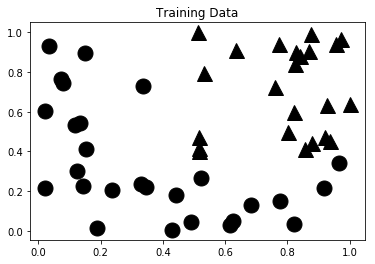

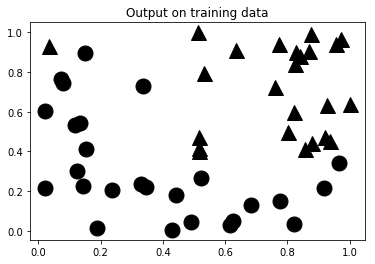

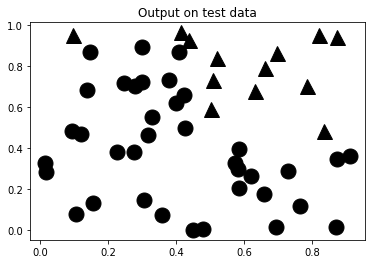

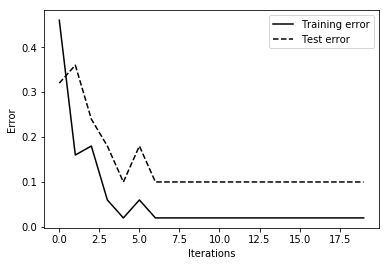

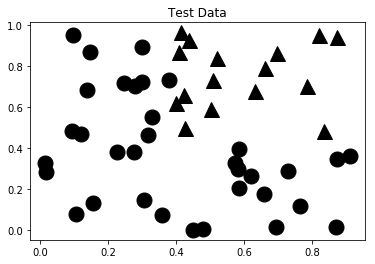

In [6]:
test_boost()